In [58]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass

import warnings

warnings.warn = warn

In [59]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os
import joblib
from datetime import datetime


from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, make_scorer


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline, make_pipeline

In [60]:
if(os.path.exists("../../data/train_test_validate_data/train_test_data.csv")):
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")
else:
    ownership_df_class = pd.read_csv("../../data/final_data/final_ownership_data.csv")
    sales_df_reg = pd.read_csv("../../data/final_data/final_sales_data.csv")
    
    ownership_df_class = ownership_df_class.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg[['Annual_Income', 'Price']]

    def find_closest_income_match(target_income, reference_df):
        closest_income_idx = (reference_df['Annual_Income'] - target_income).abs().idxmin()
        return reference_df.loc[closest_income_idx, 'Price']

    ownership_df_class['Price'] = ownership_df_class.apply(
        lambda row: find_closest_income_match(row['Annual_Income'], sales_df_reg)
        if row['Car'] == 'Yes'
        else 0,
        axis=1
        )

    ownership_sales = ownership_df_class.__deepcopy__()
    ownership_sales.to_csv(path_or_buf="../../data/train_test_validate_data/train_test_data.csv")
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")

In [61]:
data

,Unnamed: 0,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children,Price
0,0,Teacher,52800.0,750,10,Good,Yes,2,57000
1,1,Engineer,79200.0,800,8,Good,Yes,1,15000
2,2,Nurse,33000.0,650,5,Fair,No,0,0
3,3,Doctor,105600.0,900,12,Excellent,Yes,3,26001
4,4,Businessman,132000.0,700,15,Good,Yes,2,26001
...,...,...,...,...,...,...,...,...,...
391,391,Customer Support,4620.0,640,3,Stable,No,1,0
392,392,Dental Hygienist,6336.0,670,4,Stable,Yes,2,19000
393,393,Project Manager,9240.0,730,5,Stable,Yes,0,39000
394,394,Medical Assistant,4620.0,640,3,Stable,No,1,0


In [62]:
data_class = data.__deepcopy__()
data_reg = data.__deepcopy__()

In [63]:
data_class = data_class.drop(columns=['Price', 'Unnamed: 0'])
data_class

,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
0,Teacher,52800.0,750,10,Good,Yes,2
1,Engineer,79200.0,800,8,Good,Yes,1
2,Nurse,33000.0,650,5,Fair,No,0
3,Doctor,105600.0,900,12,Excellent,Yes,3
4,Businessman,132000.0,700,15,Good,Yes,2
...,...,...,...,...,...,...,...
391,Customer Support,4620.0,640,3,Stable,No,1
392,Dental Hygienist,6336.0,670,4,Stable,Yes,2
393,Project Manager,9240.0,730,5,Stable,Yes,0
394,Medical Assistant,4620.0,640,3,Stable,No,1


In [64]:
data_reg = data_reg.where(cond=(data_reg['Car'] == 'Yes')).dropna(axis=0).drop(columns=['Unnamed: 0', 'Car', 'Occupation'])
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price
0,52800.0,750.0,10.0,Good,2.0,57000.0
1,79200.0,800.0,8.0,Good,1.0,15000.0
3,105600.0,900.0,12.0,Excellent,3.0,26001.0
4,132000.0,700.0,15.0,Good,2.0,26001.0
6,46200.0,700.0,8.0,Fair,-1.0,15001.0
...,...,...,...,...,...,...
388,5940.0,670.0,4.0,Stable,2.0,17000.0
389,6336.0,660.0,3.0,Stable,1.0,19000.0
390,11220.0,750.0,7.0,Stable,0.0,13000.0
392,6336.0,670.0,4.0,Stable,2.0,19000.0


In [65]:
data_reg['Finance_Status'].unique()

array(['Good', 'Excellent', 'Fair', 'Stable', 'Unstable', 'Unknown'],
      dtype=object)

In [66]:
label_mapping = {
    'Unknown': 0,      
    'Unstable': 1,     
    'Fair': 2,         
    'Stable': 3,       
    'Good': 4,         
    'Excellent': 5     
}


In [67]:
data_reg['Finance_Status'] = data_reg['Finance_Status'].replace(label_mapping)
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price
0,52800.0,750.0,10.0,4,2.0,57000.0
1,79200.0,800.0,8.0,4,1.0,15000.0
3,105600.0,900.0,12.0,5,3.0,26001.0
4,132000.0,700.0,15.0,4,2.0,26001.0
6,46200.0,700.0,8.0,2,-1.0,15001.0
...,...,...,...,...,...,...
388,5940.0,670.0,4.0,3,2.0,17000.0
389,6336.0,660.0,3.0,3,1.0,19000.0
390,11220.0,750.0,7.0,3,0.0,13000.0
392,6336.0,670.0,4.0,3,2.0,19000.0


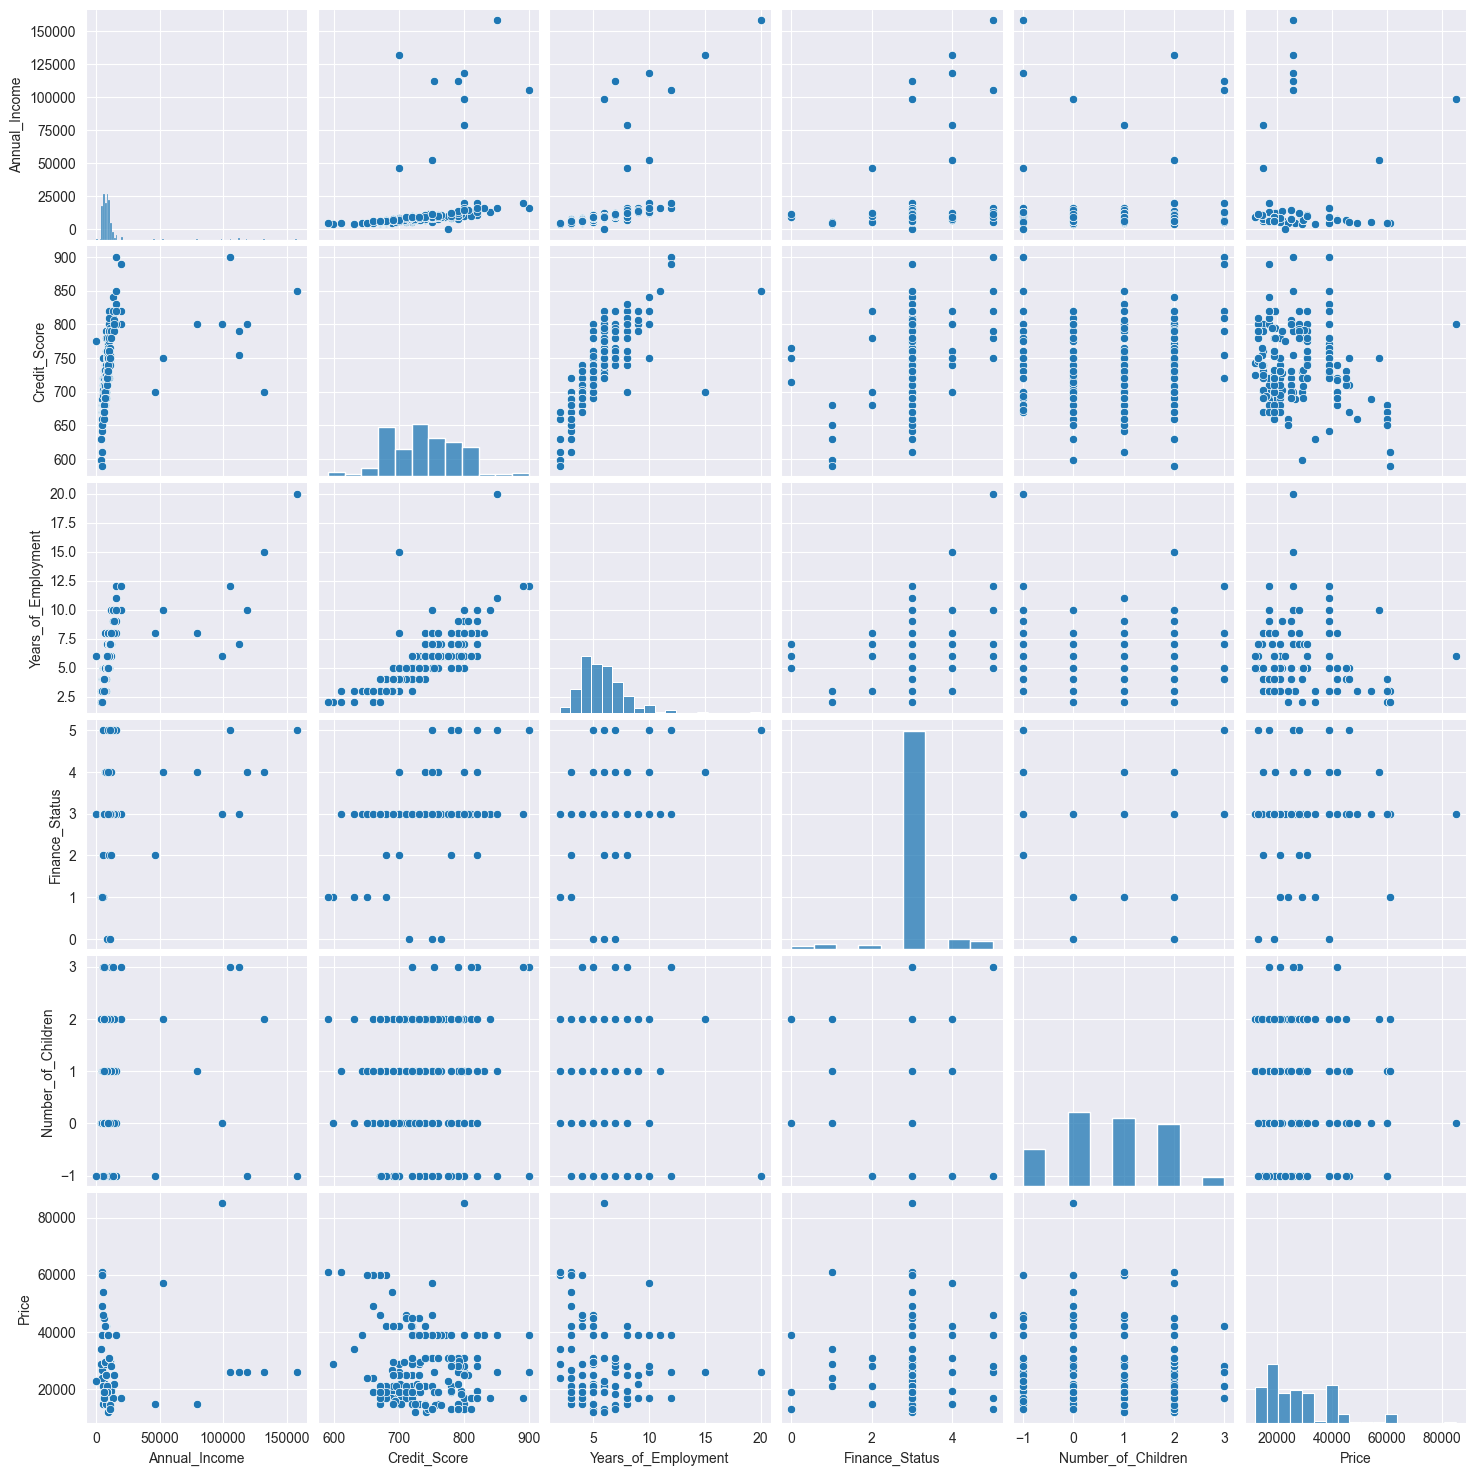

In [68]:
sns.pairplot(data_reg)

In [69]:
data_reg = data_reg.where((data_reg['Annual_Income'] < 45000)).dropna(axis=0)
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price
10,7920.0,700.0,3.0,4.0,-1.0,15000.0
12,5280.0,750.0,5.0,5.0,-1.0,46000.0
13,10560.0,800.0,7.0,4.0,-1.0,31000.0
14,11880.0,820.0,10.0,5.0,-1.0,28000.0
15,15840.0,900.0,12.0,5.0,-1.0,39000.0
...,...,...,...,...,...,...
388,5940.0,670.0,4.0,3.0,2.0,17000.0
389,6336.0,660.0,3.0,3.0,1.0,19000.0
390,11220.0,750.0,7.0,3.0,0.0,13000.0
392,6336.0,670.0,4.0,3.0,2.0,19000.0


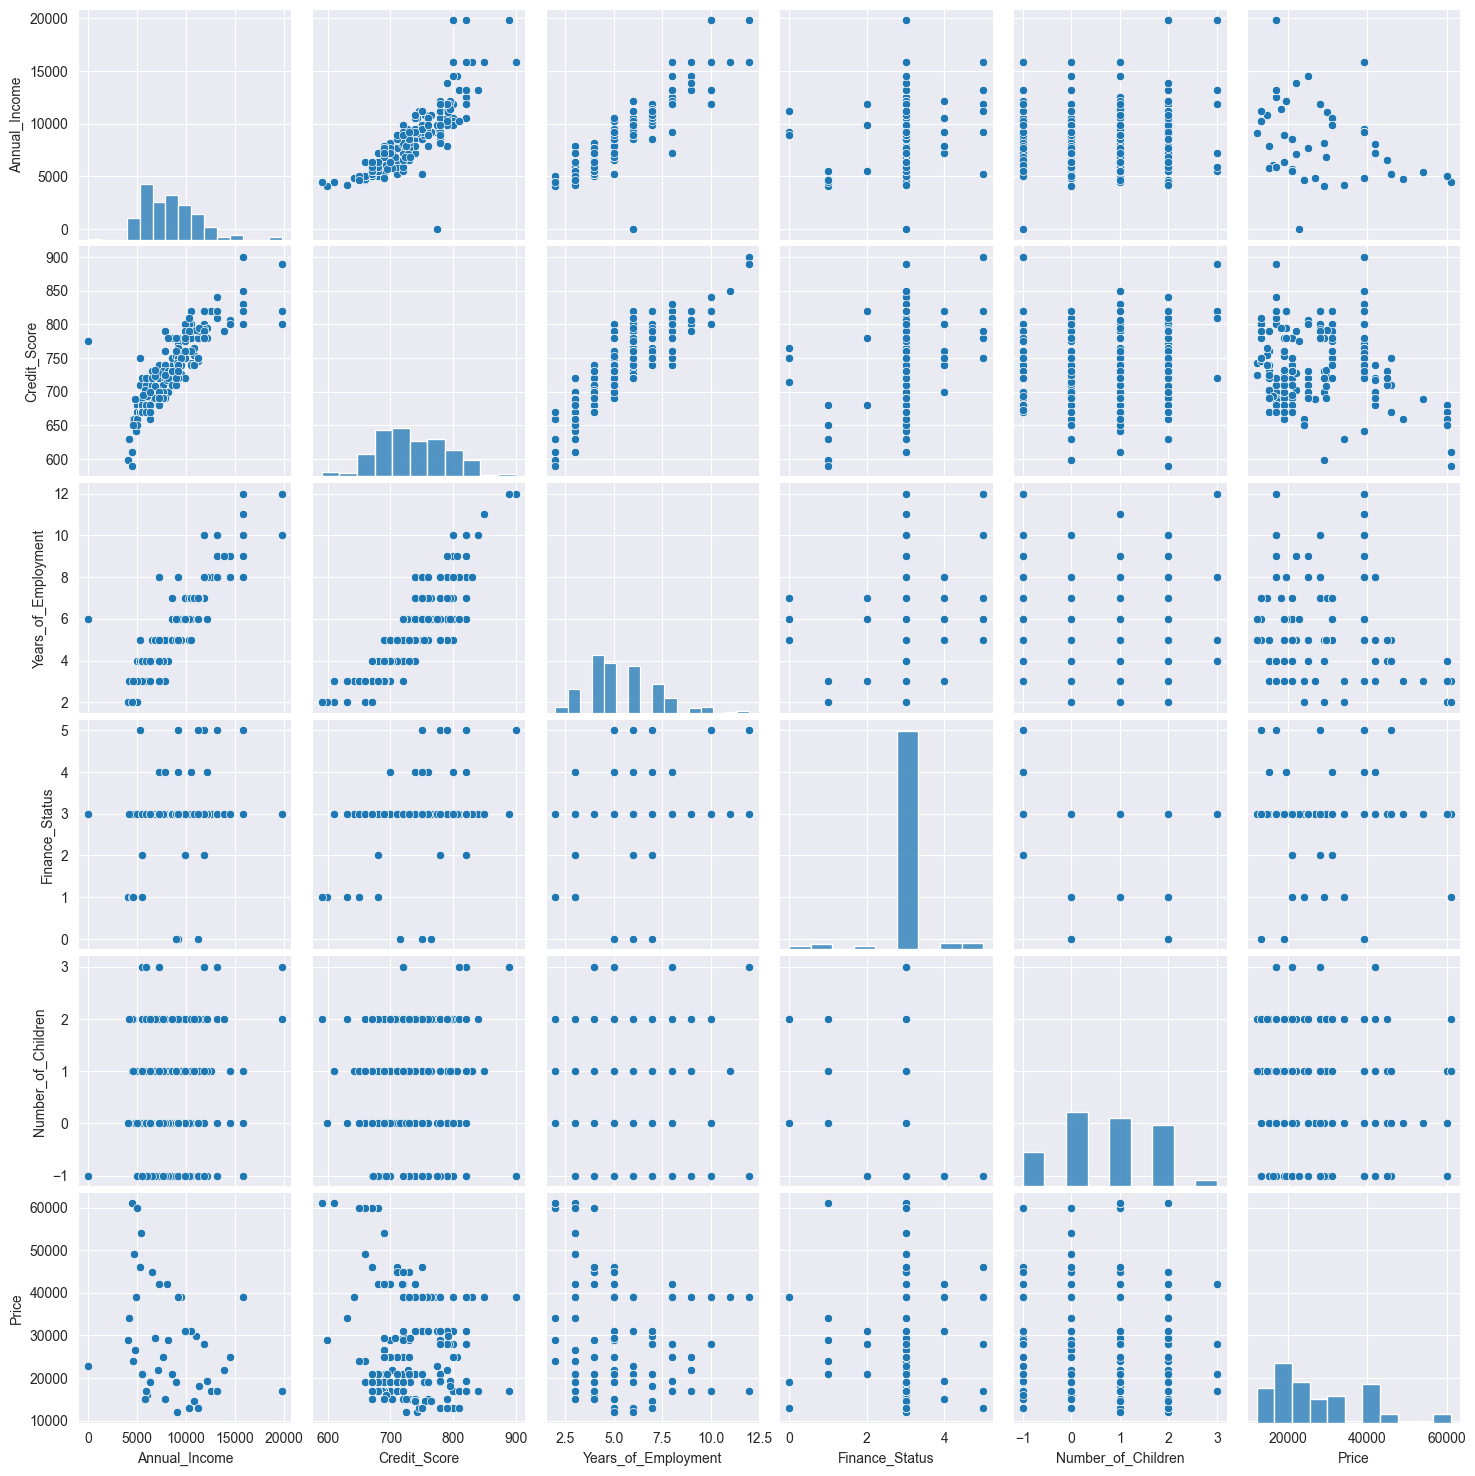

In [70]:
sns.pairplot(data_reg)

In [71]:
data_reg['Annual_Income_Credit_Score'] = data_reg['Annual_Income'] / data_reg['Credit_Score']
data_reg['Annual_Income_Years_Employment'] = data_reg['Annual_Income'] / data_reg['Years_of_Employment']
data_reg['Years_Employment_Credit_Score'] = data_reg['Credit_Score'] / data_reg['Years_of_Employment'] 
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price,Annual_Income_Credit_Score,Annual_Income_Years_Employment,Years_Employment_Credit_Score
10,7920.0,700.0,3.0,4.0,-1.0,15000.0,11.314286,2640.000000,233.333333
12,5280.0,750.0,5.0,5.0,-1.0,46000.0,7.040000,1056.000000,150.000000
13,10560.0,800.0,7.0,4.0,-1.0,31000.0,13.200000,1508.571429,114.285714
14,11880.0,820.0,10.0,5.0,-1.0,28000.0,14.487805,1188.000000,82.000000
15,15840.0,900.0,12.0,5.0,-1.0,39000.0,17.600000,1320.000000,75.000000
...,...,...,...,...,...,...,...,...,...
388,5940.0,670.0,4.0,3.0,2.0,17000.0,8.865672,1485.000000,167.500000
389,6336.0,660.0,3.0,3.0,1.0,19000.0,9.600000,2112.000000,220.000000
390,11220.0,750.0,7.0,3.0,0.0,13000.0,14.960000,1602.857143,107.142857
392,6336.0,670.0,4.0,3.0,2.0,19000.0,9.456716,1584.000000,167.500000


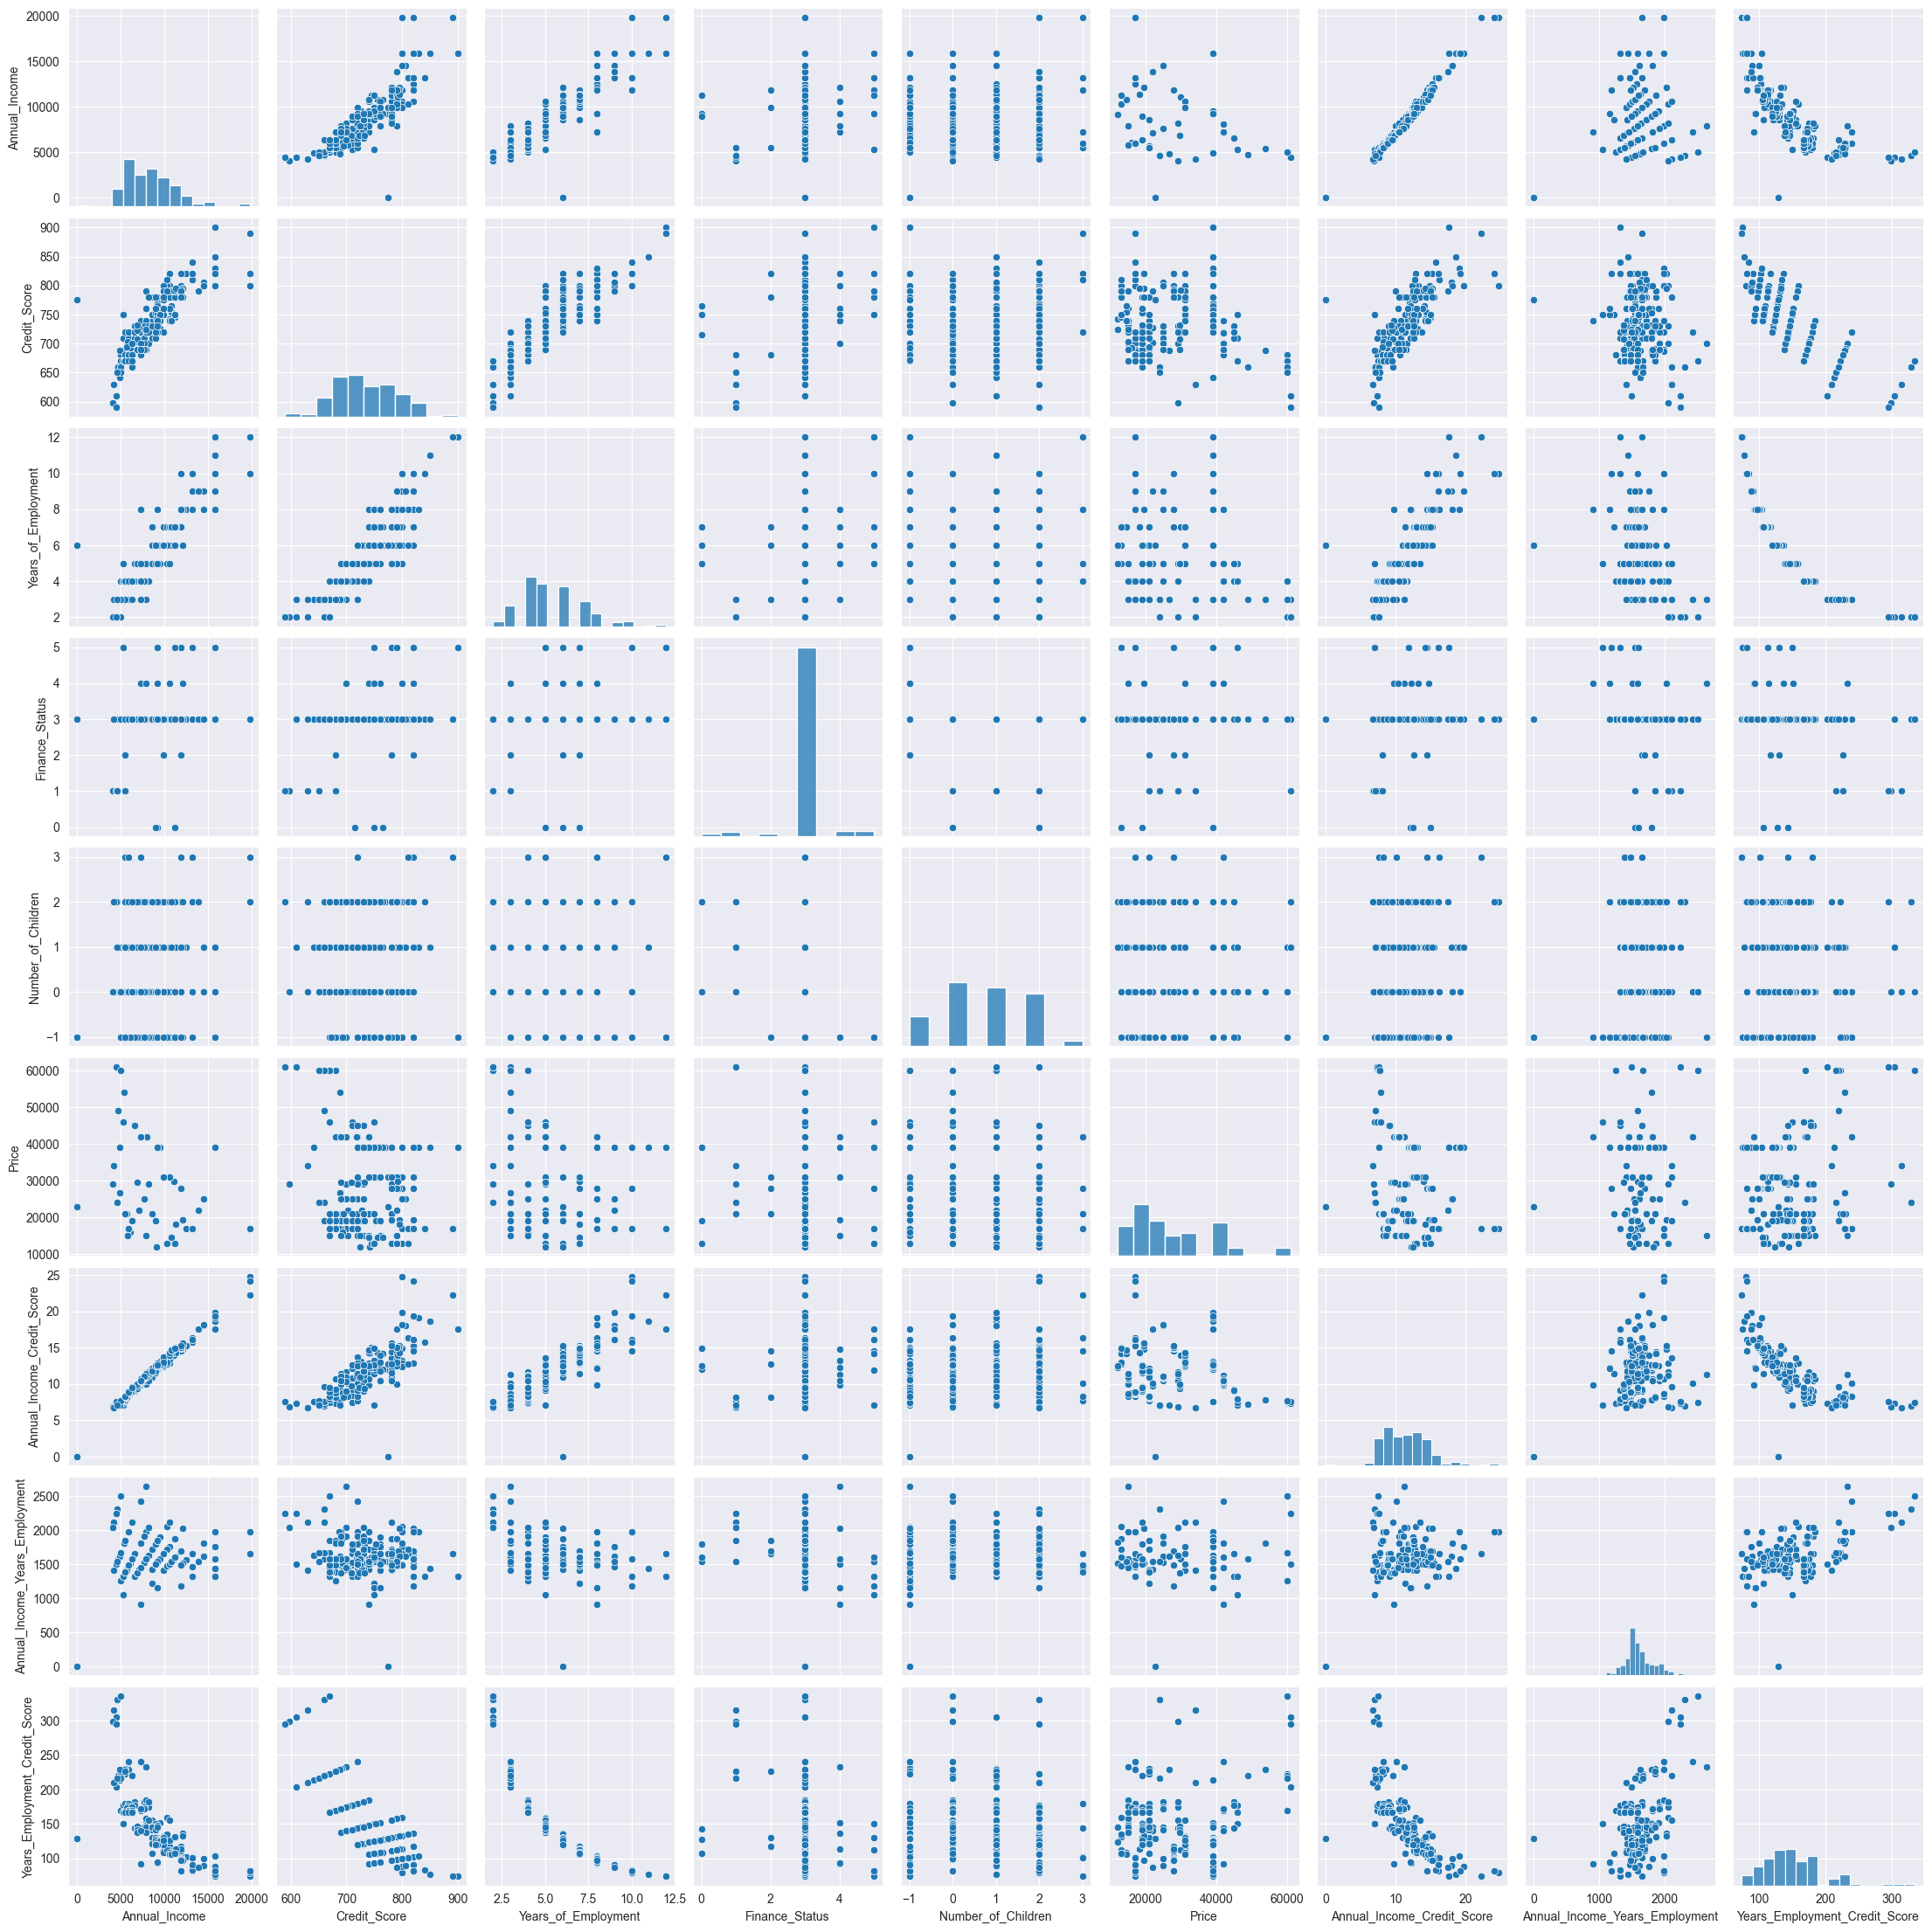

In [72]:
sns.pairplot(data_reg)

In [73]:
Y = data_reg['Price']
X = data_reg.drop(columns=['Price'])
X

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Annual_Income_Credit_Score,Annual_Income_Years_Employment,Years_Employment_Credit_Score
10,7920.0,700.0,3.0,4.0,-1.0,11.314286,2640.000000,233.333333
12,5280.0,750.0,5.0,5.0,-1.0,7.040000,1056.000000,150.000000
13,10560.0,800.0,7.0,4.0,-1.0,13.200000,1508.571429,114.285714
14,11880.0,820.0,10.0,5.0,-1.0,14.487805,1188.000000,82.000000
15,15840.0,900.0,12.0,5.0,-1.0,17.600000,1320.000000,75.000000
...,...,...,...,...,...,...,...,...
388,5940.0,670.0,4.0,3.0,2.0,8.865672,1485.000000,167.500000
389,6336.0,660.0,3.0,3.0,1.0,9.600000,2112.000000,220.000000
390,11220.0,750.0,7.0,3.0,0.0,14.960000,1602.857143,107.142857
392,6336.0,670.0,4.0,3.0,2.0,9.456716,1584.000000,167.500000


In [74]:
Y

10     15000.0
12     46000.0
13     31000.0
14     28000.0
15     39000.0
        ...   
388    17000.0
389    19000.0
390    13000.0
392    19000.0
393    39000.0
Name: Price, Length: 240, dtype: float64

In [75]:
def create_model_pipelines():
    """Create dictionary of model pipelines with their parameter grids"""

    models = {
        'XGBoost': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', XGBRegressor(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600],  # Extended range around 250
                'model__max_depth': [4, 5, 6, 7],  # Slightly deeper trees
                'model__learning_rate': [0.08, 0.1, 0.15],  # Added higher learning rate
                'model__min_child_weight': [2, 3],  # Increased from previous
                'model__subsample': [0.85, 0.9, 0.95],  # Higher subsample ratios
                'model__colsample_bytree': [0.85, 0.9, 0.95],  # Higher column sample ratios
                'model__gamma': [0, 0.05, 0.1]  # Finer gamma control
            }
        },

        'Gradient_Boosting': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600],  # Extended around successful 250
                'model__learning_rate': [0.08, 0.1, 0.15],  # Added higher learning rate option
                'model__max_depth': [4, 5, 6],  # Centered around successful 5
                'model__min_samples_split': [5, 6, 7],  # Centered around successful 6
                'model__min_samples_leaf': [1, 2, 3]  # Extended from successful 2
            }
        },

        'Random_Forest': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600],  # Matched GB range
                'model__max_depth': [5, 6, 7, 8],  # Slightly deeper than GB
                'model__min_samples_split': [5, 6, 7],  # Matched GB
                'model__min_samples_leaf': [2, 3, 4],  # Increased based on GB success with 2
                'model__max_features': ['sqrt', 'log2', None]  # Added None for all features
            }
        },

        'LightGBM': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('model', LGBMRegressor(random_state=42))
            ]),
            'params': {
                'model__n_estimators': [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600],  # Matched others
                'model__learning_rate': [0.08, 0.1, 0.15],  # Matched others
                'model__max_depth': [4, 5, 6, 7],  # Extended range
                'model__num_leaves': [25, 31, 40, 50],  # Wider range for better optimization
                'model__min_child_samples': [2, 3, 4],  # Based on GB min_samples_leaf
                'model__subsample': [0.85, 0.9, 0.95],  # Higher ratios
                'model__colsample_bytree': [0.85, 0.9, 0.95]  # Higher ratios
            }
        }
    }

    return models

def train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5, r2_threshold=0.7):
    """
    Train models using GridSearchCV and evaluate their performance
    
    Parameters:
    X_train, X_test : feature matrices for train and test sets
    y_train, y_test : target vectors for train and test sets
    cv : number of cross-validation folds (default=5)
    r2_threshold : minimum R2 score for models to be included in voting ensemble
    
    Returns:
    tuple: (results DataFrame, dictionary of best models, voting regressor)
    """

    # Get model pipelines and their parameter grids
    models = create_model_pipelines()

    # Store results and best models
    results = []
    best_models = {}

    # Train and evaluate each model
    for name, model_info in models.items():
        print(f"\nTraining {name}...")

        # Create and train GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_info['pipeline'],
            param_grid=model_info['params'],
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        # Get the best model
        best_models[name] = grid_search.best_estimator_

        # Make predictions
        train_pred = grid_search.predict(X_train)
        test_pred = grid_search.predict(X_test)

        # Calculate metrics
        results.append({
            'Model': name,
            'Best Parameters': grid_search.best_params_,
            'Train R2': r2_score(y_train, train_pred),
            'Test R2': r2_score(y_test, test_pred),
            'Train MSE': mean_squared_error(y_train, train_pred),
            'Test MSE': mean_squared_error(y_test, test_pred),
            'Train MAE': mean_absolute_error(y_train, train_pred),
            'Test MAE': mean_absolute_error(y_test, test_pred)
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Create voting regressor from best performing models
    good_models = []
    for name, model in best_models.items():
        if results_df.loc[results_df['Model'] == name, 'Test R2'].values[0] >= r2_threshold:
            good_models.append((name, model))

    if len(good_models) > 1:
        print(f"\nCreating Voting Regressor with models that have R2 >= {r2_threshold}:")
        for name, _ in good_models:
            print(f"- {name}")

        voting_regressor = VotingRegressor(
            estimators=good_models,
            weights=[1] * len(good_models)  # Equal weights for all models
        )

        # Train voting regressor
        voting_regressor.fit(X_train, y_train)

        # Add voting regressor results
        y_train_pred = voting_regressor.predict(X_train)
        y_test_pred = voting_regressor.predict(X_test)

        results.append({
            'Model': 'Voting_Regressor',
            'Best Parameters': {'estimators': [name for name, _ in good_models]},
            'Train R2': r2_score(y_train, y_train_pred),
            'Test R2': r2_score(y_test, y_test_pred),
            'Train MSE': mean_squared_error(y_train, y_train_pred),
            'Test MSE': mean_squared_error(y_test, y_test_pred),
            'Train MAE': mean_absolute_error(y_train, y_train_pred),
            'Test MAE': mean_absolute_error(y_test, y_test_pred)
        })

        # Update results DataFrame
        results_df = pd.DataFrame(results)
        best_models['Voting_Regressor'] = voting_regressor

    return results_df, best_models

def get_best_model_results(results_df, best_models, X_test, y_test):
    """Print detailed results for the best performing model and save it"""

    # Find the best model based on test R2 score
    best_model_name = results_df.loc[results_df['Test R2'].idxmax(), 'Model']
    best_model = best_models[best_model_name]

    # Make predictions on test data
    y_pred = best_model.predict(X_test)

    # Calculate metrics on test data
    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)

    print("\nBest Model:", best_model_name)
    print("\nBest Model Parameters:")
    print(results_df.loc[results_df['Model'] == best_model_name, 'Best Parameters'].values[0])

    print("\nBest Model Performance on Test Data:")
    print(f"R2 Score: {test_r2:.4f}")
    print(f"MSE: {test_mse:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")

    # Calculate and print residuals statistics
    residuals = y_test - y_pred
    print("\nResiduals Statistics:")
    print(f"Mean Residual: {np.mean(residuals):.4f}")
    print(f"Std Residual: {np.std(residuals):.4f}")
    print(f"Min Residual: {np.min(residuals):.4f}")
    print(f"Max Residual: {np.max(residuals):.4f}")

    # Save the model
    model_dir = '../../models/'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"\nCreated directory: {model_dir}")

    # Create filename with timestamp and performance metric
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"best_model_{best_model_name}_R2_{test_r2:.4f}_{timestamp}.joblib"
    model_path = os.path.join(model_dir, filename)

    # Save the model
    joblib.dump(best_model, model_path)
    print(f"\nBest model saved to: {model_path}")

    # Save model info to a text file
    info_filename = f"model_info_{timestamp}.txt"
    info_path = os.path.join(model_dir, info_filename)

    with open(info_path, 'w') as f:
        f.write(f"Model Name: {best_model_name}\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        f.write("Performance Metrics:\n")
        f.write(f"R2 Score: {test_r2:.4f}\n")
        f.write(f"MSE: {test_mse:.4f}\n")
        f.write(f"RMSE: {test_rmse:.4f}\n")
        f.write(f"MAE: {test_mae:.4f}\n\n")
        f.write("Model Parameters:\n")
        f.write(str(results_df.loc[results_df['Model'] == best_model_name, 'Best Parameters'].values[0]))

    print(f"Model information saved to: {info_path}")

    return best_model


In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

results_df, best_models = train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5, r2_threshold=0.7)

print("\nAll Models Comparison:")
print(results_df[['Model', 'Test R2', 'Test MSE', 'Test MAE']])

best_model = get_best_model_results(results_df, best_models, X_test, y_test)

predictions = best_model.predict(X_test)


Training XGBoost...
Fitting 5 folds for each of 7128 candidates, totalling 35640 fits

Training Gradient_Boosting...
Fitting 5 folds for each of 891 candidates, totalling 4455 fits

Training Random_Forest...
Fitting 5 folds for each of 1188 candidates, totalling 5940 fits

Training LightGBM...
Fitting 5 folds for each of 14256 candidates, totalling 71280 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 8
[LightGBM] [Info] Start training from score 27146.968750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 